Notebook to verfiy that after linearization linear loss is zero along the same posterior path.

In [1]:
import numpy as np
import os
import wandb
import matplotlib.pyplot as plt
import tensorflow as tf
from gpflow.config import default_float
from gpflow.likelihoods import Gaussian

from docs.sde.sde_exp_utils import generate_dw_data
from markovflow.sde.sde import DoubleWellSDE, PriorDoubleWellSDE
from markovflow.models.cvi_sde import SDESSM
from markovflow.models.vi_sde import VariationalMarkovGP
from markovflow.sde.sde_utils import KL_sde

from IPython.display import clear_output


2022-07-14 17:29:13.572568: W tensorflow/stream_executor/platform/default/dso_loader.cc:60] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2022-07-14 17:29:13.572609: I tensorflow/stream_executor/cuda/cudart_stub.cc:29] Ignore above cudart dlerror if you do not have a GPU set up on your machine.
2022-07-14 17:29:15.705848: I tensorflow/compiler/jit/xla_cpu_device.cc:41] Not creating XLA devices, tf_xla_enable_xla_devices not set
2022-07-14 17:29:15.706981: I tensorflow/stream_executor/platform/default/dso_loader.cc:49] Successfully opened dynamic library libcuda.so.1
2022-07-14 17:29:15.731327: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:941] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2022-07-14 17:29:15.731635: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1720] Found device 0 with properties

In [2]:
# Set seed
tf.random.set_seed(12)
np.random.seed(12)

## Parameters

In [3]:
DTYPE = default_float()
q = 1.  # Set this to one so that later calculations become convenient while testing
x0 = 1.
t0 = 0.
t1 = 30.
dt = 0.01
noise_var = 0.01

## Data

In [4]:
obs_vals, obs_grid, latent_process, time_grid, _, _, _ = generate_dw_data(q=q, x0=x0, t0=t0, t1=t1,
                                                                            simulation_dt=dt,
                                                                            noise_stddev=np.sqrt(noise_var),
                                                                            n_observations=40,
                                                                            dtype=DTYPE)

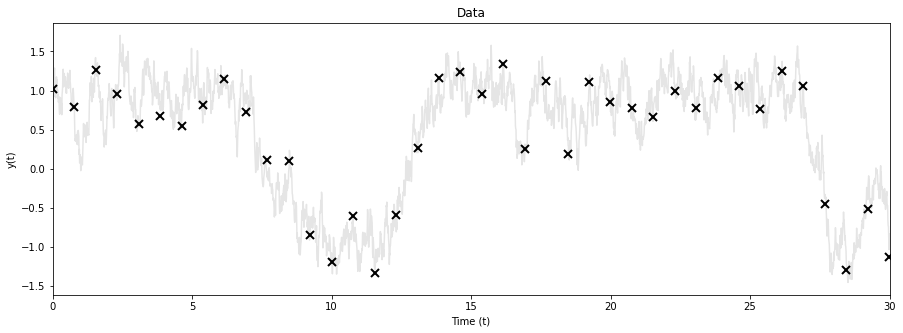

In [5]:
plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")
plt.plot(obs_grid.numpy().reshape(-1), obs_vals.numpy().reshape(-1), 'kx', ms=8, mew=2, label="Observations (Y)")
plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.title("Data")
plt.show()

## Model

In [6]:
# Prior SDE
true_q = q * tf.ones((1, 1), dtype=DTYPE)
prior_sde = PriorDoubleWellSDE(q=true_q, initial_a_val=4., initial_c_val=1.)

# likelihood
likelihood = Gaussian(noise_var)

obs_data = (obs_grid, tf.squeeze(obs_vals, axis=0))

In [7]:
ssm_model = SDESSM(input_data=obs_data, prior_sde=prior_sde, grid=time_grid, likelihood=likelihood)

# Set initial statistics and posterior path
ssm_model.initial_mean = 1. + 0. * ssm_model.initial_mean
ssm_model.initial_chol_cov = .5 + 0. * ssm_model.initial_chol_cov

ssm_model.fx_mus = tf.reshape(latent_process, ssm_model.fx_mus.shape)

ssm_model.linearization_pnts = (tf.identity(ssm_model.fx_mus[:, :-1, :]), 
                                tf.identity(ssm_model.fx_covs[:, :-1, :, :]))
ssm_model._linearize_prior()

2022-07-14 17:29:26.897638: W tensorflow/python/util/util.cc:348] Sets are not currently considered sequences, but this may change in the future, so consider avoiding using them.


In [8]:
ssm_model.fx_covs

<tf.Tensor: shape=(1, 3001, 1, 1), dtype=float64, numpy=
array([[[[0.5]],

        [[0.5]],

        [[0.5]],

        ...,

        [[0.5]],

        [[0.5]],

        [[0.5]]]])>

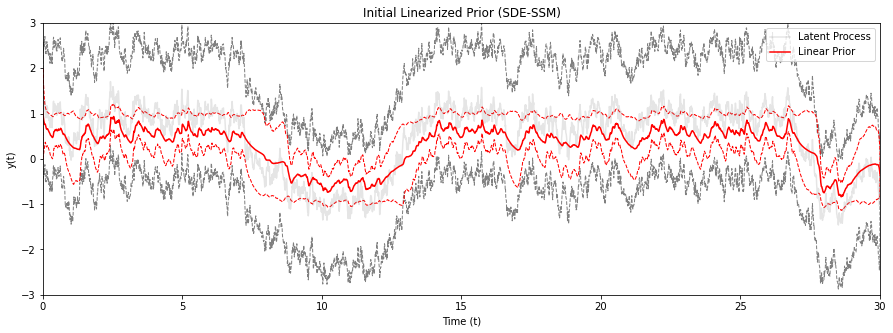

In [9]:
ssm_lin_prior_marginals = ssm_model.dist_p_ssm.marginals

ssm_lin_prior_m = ssm_lin_prior_marginals[0].numpy().reshape(-1)
ssm_lin_prior_S = ssm_lin_prior_marginals[1].numpy().reshape(-1)

plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")
plt.fill_between(
            time_grid,
            y1=(tf.reshape(latent_process, (-1)) - 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            y2=(tf.reshape(latent_process, (-1)) + 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            edgecolor="gray",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

plt.plot(time_grid, ssm_lin_prior_m, label="Linear Prior", color="red")
plt.fill_between(
            time_grid,
            y1=(ssm_lin_prior_m - 2 * np.sqrt(ssm_lin_prior_S)),
            y2=(ssm_lin_prior_m + 2 * np.sqrt(ssm_lin_prior_S)),
            edgecolor="red",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.ylim([-3 ,3])
plt.title("Initial Linearized Prior (SDE-SSM)")
plt.legend()
plt.show()

In [12]:
A = tf.squeeze(ssm_model.dist_p_ssm.state_transitions, axis=0)
A = (A - tf.eye(1, dtype=A.dtype))/dt
A

<tf.Tensor: shape=(3000, 1, 1), dtype=float64, numpy=
array([[[-14.        ]],

       [[-13.70386534]],

       [[-13.99155571]],

       ...,

       [[-11.83728001]],

       [[-14.93493292]],

       [[-14.358688  ]]])>

## Changing fx_covs

In [13]:
ssm_model.fx_covs = .1 + 0. * ssm_model.fx_covs
ssm_model.linearization_pnts = (tf.identity(ssm_model.fx_mus[:, :-1, :]), 
                                tf.identity(ssm_model.fx_covs[:, :-1, :, :]))
ssm_model._linearize_prior()

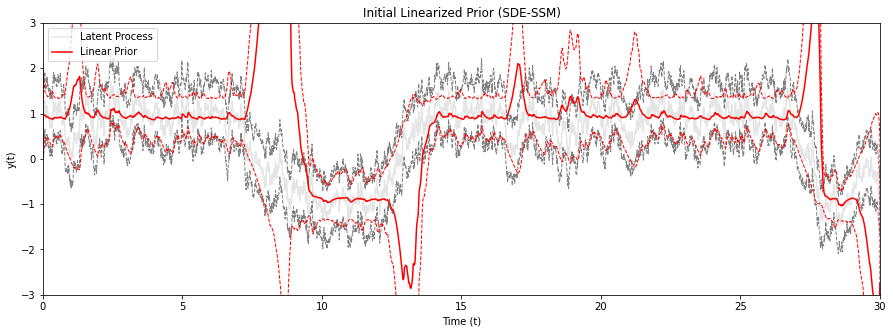

In [14]:
ssm_lin_prior_marginals = ssm_model.dist_p_ssm.marginals

ssm_lin_prior_m = ssm_lin_prior_marginals[0].numpy().reshape(-1)
ssm_lin_prior_S = ssm_lin_prior_marginals[1].numpy().reshape(-1)

plt.rcParams["figure.figsize"] = [15, 5]
plt.plot(time_grid, tf.reshape(latent_process, (-1)), label="Latent Process", alpha=0.2, color="gray")
plt.fill_between(
            time_grid,
            y1=(tf.reshape(latent_process, (-1)) - 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            y2=(tf.reshape(latent_process, (-1)) + 2 * np.sqrt(ssm_model.fx_covs.numpy().reshape(-1))),
            edgecolor="gray",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

plt.plot(time_grid, ssm_lin_prior_m, label="Linear Prior", color="red")
plt.fill_between(
            time_grid,
            y1=(ssm_lin_prior_m - 2 * np.sqrt(ssm_lin_prior_S)),
            y2=(ssm_lin_prior_m + 2 * np.sqrt(ssm_lin_prior_S)),
            edgecolor="red",
            facecolor=(0, 0, 0, 0.),
            linestyle='dashed'
        )

plt.xlabel("Time (t)")
plt.ylabel("y(t)")
plt.xlim([t0, t1])
plt.ylim([-3 ,3])
plt.title("Initial Linearized Prior (SDE-SSM)")
plt.legend()
plt.show()

In [15]:
# We know the closed form value of linearized drift's A value

true_a = 4*(1-3*(ssm_model.linearization_pnts[0].numpy().reshape(-1)**2 + 
                 ssm_model.linearization_pnts[1].numpy().reshape(-1))) 

A = tf.squeeze(ssm_model.dist_p_ssm.state_transitions, axis=0)
A = (A - tf.eye(1, dtype=A.dtype))/dt

np.testing.assert_array_almost_equal(true_a, A.numpy().reshape(-1))


true_b = 8 * ssm_model.linearization_pnts[0].numpy().reshape(-1)**3
b = tf.squeeze(ssm_model.dist_p_ssm.state_offsets, axis=0)
b = b / dt
np.testing.assert_array_almost_equal(true_b, b.numpy().reshape(-1))

In [16]:
true_a

array([ -9.2       ,  -8.90386534,  -9.19155571, ...,  -7.03728001,
       -10.13493292,  -9.558688  ])

In [17]:
A

<tf.Tensor: shape=(3000, 1, 1), dtype=float64, numpy=
array([[[ -9.2       ]],

       [[ -8.90386534]],

       [[ -9.19155571]],

       ...,

       [[ -7.03728001]],

       [[-10.13493292]],

       [[ -9.558688  ]]])>

## Lin Loss code copied from the model class for debuging

In [12]:
dt = time_grid[1] - time_grid[0]

# removing batch and the last m and S. FIXME: check last point removal
m = tf.squeeze(ssm_model.fx_mus, axis=0)[:-1]
S = tf.squeeze(ssm_model.fx_covs, axis=0)[:-1]

# convert from state transitons of the SSM to SDE P's drift and offset
A = tf.squeeze(ssm_model.dist_p_ssm.state_transitions, axis=0)
b = tf.squeeze(ssm_model.dist_p_ssm.state_offsets, axis=0)
A = (A - tf.eye(1, dtype=A.dtype))/dt
b = b / dt

# -1 * A as the function expects A without the negative sign i.e. drift = - A*x + b
lin_loss = KL_sde(prior_sde, -A, b, m, S, dt=dt)

In [13]:
lin_loss.numpy()

36.42004027381646

In [14]:
def gaussian_moments(mean, var, n):
    """
    Univariate Gaussian Moments
    MGF = exp(/mu t + (1/2)*sigma^2*t^2)
    n moment = d^n(MGF)/dt^n evaluated at t=0.
    """
    assert n >= 0, "Moments only defined for n>=0"
    if n == 0: return 1
    moment_vals = [mean, var + mean**2]
    for i in range(2, n):
        moment_vals.append(var * i*moment_vals[i-2] + mean*moment_vals[i-1])

    return moment_vals[n-1]

In [15]:
# Expected Linear loss value
m = ssm_model.linearization_pnts[0].numpy().reshape(-1)
S = ssm_model.linearization_pnts[1].numpy().reshape(-1)

A = A.numpy().reshape(-1)
b = b.numpy().reshape(-1)

e6 = gaussian_moments(m, S, 6)
e4 = gaussian_moments(m, S, 4)
e3 = gaussian_moments(m, S, 3)
e2 = gaussian_moments(m, S, 2)

term1 = 8 * e6
term2 = 4 * (4-A) * e4
term3 = 4 * b * e3
term4 = 0.5 * (A-4)**2 * e2
term5 = b * m * (4 - A)
term6 = b**2/2

expected_loss = term1 - term2 + term3 + term4 - term5 + term6

In [16]:
np.sum(expected_loss) * dt

<tf.Tensor: shape=(), dtype=float64, numpy=36.42004027381648>